# Demo 2: Adding Non-Linearity with a Single Activation Layer

Neural networks are famous for solving complex, curved patterns in data. But how do they create those curves? The secret lies in a simple mathematical function applied after computing the weighted sum: the activation function.

> **Overview**: We'll build a network with a single non-linear activation function and see how adding a sigmoid activation function transforms a linear model into one that can capture curved, elliptical patterns in data.
> 
> **Scenario**: Your smart greenhouse monitors temperature and moisture to predict plant health. The specific crop you're monitoring thrives only when BOTH temperature AND moisture are in moderate ranges. This creates an elliptical "Goldilocks zone" in your data: too hot, too cold, too wet, or too dry all lead to unhealthy plants. _Can a neural network with activation functions capture this curved boundary_
> 
> **Goal**: Understand how activation functions enable a layer to create curved decision boundaries, and visualize exactly how they transform data space to make complex patterns learnable.
> 
> **Tools**: Python, PyTorch, NumPy, Matplotlib

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
import re
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for visualizations
output_dir = 'assets/demo2'
os.makedirs(output_dir, exist_ok=True)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Setup complete!\n")

Using device: cuda
Setup complete!



## Step 2: Load and prepare the data

We'll use the [Praxash1/AIgrow](https://huggingface.co/datasets/Praxash1/AIgrow) dataset from Hugging Face, which contains real agricultural data, including temperature and soil moisture measurements. 

For preprocessing, we'll:
1. _Load data_
2. Parse temperature and moisture readings from text entries
3. Augment the small dataset for better visualization
4. Normalize the features for our neural network
5. Create the final dataset X _(in numpy array format)_
6. Create health labels based on environmental patterns _(that create an elliptical decision boundary)_

**IMPORTANT: Feel free to skip this section to focus on the activation function itself**. Just know that we end up with 400 examples, each with temperature and moisture measurements, labeled as healthy (1) or unhealthy (0) based on whether plants can thrive in specific conditions. The pattern is non-linear: only mild conditions for both temperature and moisture are healthy.


In [2]:
# 1. Load the dataset
dataset = load_dataset('Praxash1/AIgrow', split='train')
print(f"✓ Dataset loaded: {len(dataset)} entries found\n")

# 2. Parse the dataset
def parse_aigrow_entry(text):
    """Extract temperature and moisture from dataset text entries."""
    data = {}
    
    # Extract soil moisture
    moisture_match = re.search(r'Soil Moisture:\s*([\d.]+)', text)
    if moisture_match:
        data['moisture'] = float(moisture_match.group(1))
    
    # Extract temperature
    temp_match = re.search(r'Temperature:\s*([\d.]+)', text)
    if temp_match:
        data['temperature'] = float(temp_match.group(1))
    
    return data if len(data) == 2 else None

data_list = []
for item in dataset:
    parsed = parse_aigrow_entry(item['text'])
    if parsed:
        data_list.append(parsed)

print(f"✓ Parsed {len(data_list)} valid temperature-moisture readings")

✓ Dataset loaded: 16 entries found

✓ Parsed 16 valid temperature-moisture readings


> **Parsing the dataset**: The AIgrow dataset stores sensor data as text strings like "Soil Moisture: 72.19 | Temperature: 18.05 | ...". We use regular expressions to extract just the temperature (°C) and moisture (%) values we need, converting them from text to numbers our network can process.

In [3]:
# 3. Augment the dataset
# The original dataset is small (~16 samples), so we'll augment it by adding synthetic variations around the real measurements
print(f"✓ Augmenting dataset to create {400} samples for better visualization...")

original_data = pd.DataFrame(data_list)

# Generate augmented data by adding noise to original samples
augmented_data = []
target_size = 400

np.random.seed(42)
for _ in range(target_size):
    # Pick a random original sample
    base_idx = np.random.randint(0, len(original_data))
    base_temp = original_data.iloc[base_idx]['temperature']
    base_moisture = original_data.iloc[base_idx]['moisture']
    
    # Add realistic variation
    new_temp = base_temp + np.random.normal(0, 3)  # ±3°C variation
    new_moisture = base_moisture + np.random.normal(0, 5)  # ±5% variation
    
    # Clip to realistic ranges
    new_temp = np.clip(new_temp, 10, 40)
    new_moisture = np.clip(new_moisture, 5, 85)
    
    augmented_data.append({
        'temperature': new_temp,
        'moisture': new_moisture
    })

data_list = augmented_data

# 3. Convert to arrays
df = pd.DataFrame(data_list)
temperature_raw = df['temperature'].values
moisture_raw = df['moisture'].values

✓ Augmenting dataset to create 400 samples for better visualization...


> **Data augmentatin approach:**  We augment the original dataset of authentic agricultural measurements by adding realistic variations (±3°C temperature, ±5% moisture) around each original measurement, creating 400 samples that maintain the real-world patterns while enabling better learning visualization.


In [4]:
# 4. Normalize features to [0, 1] range for neural network
temperature_norm = (temperature_raw - 10) / 30  # 10-40°C -> 0-1
moisture_norm = moisture_raw / 90  # 0-90% -> 0-1

> **Why normalize features?** Neural networks learn best when all input features are on similar scales. Temperature ranges from 10-40°C while moisture ranges from 5-85%, so we normalize both to [0, 1]. This prevents the network from treating one feature as more important simply because it has larger numbers. 
> 
> Think of it as converting both measurements to "percentage of their typical range" so the network can focus on patterns, not raw magnitudes.

In [5]:
# 5. Combine feature into matrix
X = np.column_stack([temperature_norm, moisture_norm])

In [6]:
# 6. Create elliptical goldilocks zone labels
# Plants are healthy when BOTH temp and moisture are moderate
def create_elliptical_labels(temp_norm, moisture_norm, noise_rate=0.08):
    """
    Create labels for elliptical goldilocks zone.
    
    Healthy (1): Both temperature and moisture are in moderate ranges
    Unhealthy (0): Any extreme (too hot, too cold, too wet, too dry)
    """
    # Define ellipse center and radii
    center_temp = 0.5
    center_moisture = 0.5
    radius_temp = 0.25
    radius_moisture = 0.25
    
    # Calculate normalized distance from center
    dist_temp = (temp_norm - center_temp) / radius_temp
    dist_moisture = (moisture_norm - center_moisture) / radius_moisture
    ellipse_dist = np.sqrt(dist_temp**2 + dist_moisture**2)
    
    # Label as healthy if inside ellipse
    labels = (ellipse_dist < 1.0).astype(float)
    
    # Add realistic noise (sensor errors, edge cases)
    noise_mask = np.random.random(len(labels)) < noise_rate
    labels[noise_mask] = 1 - labels[noise_mask]
    
    return labels

labels = create_elliptical_labels(temperature_norm, moisture_norm, noise_rate=0.0)

> **The labeling logic**: Plants are healthy (1) when distance from center < threshold, creating an elliptical "Goldilocks zone". Formula: `sqrt((temp-0.5)²/0.25² + (moisture-0.5)²/0.25²) < 1.0`. We add 8% noise for realism. 
> 
> This crop needs BOTH moderate temp AND moderate moisture—extremes in either dimension cause stress.

In [7]:
# TO CONCLUDE: Get a high-level dataset summary
print(f"\n{'='*60}")
print("Dataset Summary:")
print(f"{'='*60}")
print(f"Total samples: {len(X)}")
print(f"\nFeature ranges (raw):")
print(f"  Temperature: {temperature_raw.min():.1f}°C to {temperature_raw.max():.1f}°C")
print(f"  Moisture: {moisture_raw.min():.1f}% to {moisture_raw.max():.1f}%")
print(f"\nFeature ranges (normalized):")
print(f"  Temperature: {X[:, 0].min():.3f} to {X[:, 0].max():.3f}")
print(f"  Moisture: {X[:, 1].min():.3f} to {X[:, 1].max():.3f}")
print(f"\nClass distribution:")
print(f"  Healthy plants (1): {int(labels.sum())} ({labels.mean()*100:.1f}%)")
print(f"  Unhealthy plants (0): {int(len(labels) - labels.sum())} ({(1-labels.mean())*100:.1f}%)")
print(f"{'='*60}")


Dataset Summary:
Total samples: 400

Feature ranges (raw):
  Temperature: 10.0°C to 40.0°C
  Moisture: 5.0% to 85.0%

Feature ranges (normalized):
  Temperature: 0.000 to 1.000
  Moisture: 0.056 to 0.944

Class distribution:
  Healthy plants (1): 65 (16.2%)
  Unhealthy plants (0): 335 (83.8%)


> **Understanding the class distribution**: Notice the class distribution is imbalanced (16.2% healthy vs 83.8% unhealthy) because most random temperature-moisture combinations aren't optimal for plants; only specific zones support healthy growth. Plant health follows complex rules: moderate conditions work, but most other combinations (hot+wet, cold+dry, or one-sided extremes) are problematic.

## Step 3: Visualize the non-linear elliptical pattern

Let's see why this problem is impossible for a single neuron, since no straight line can separate the healthy from unhealthy plants.

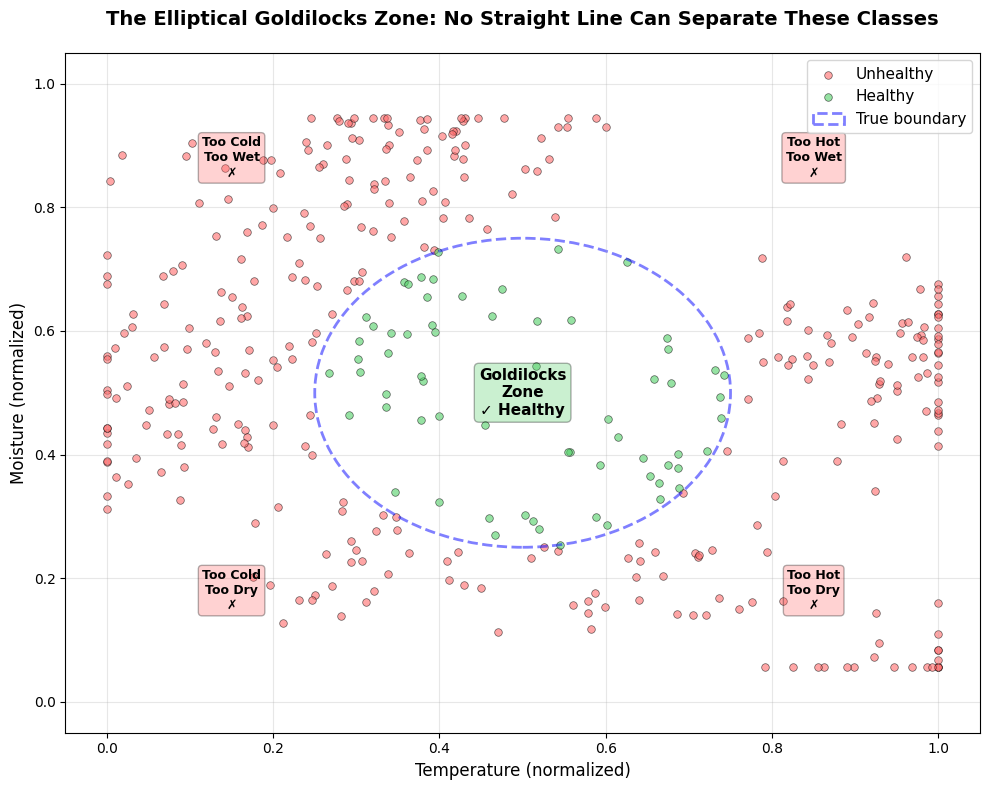


The Challenge:
• Try drawing a single straight line to separate green from red points
• Impossible! The healthy region forms an ellipse in the center
• Any straight line will either exclude healthy plants OR include unhealthy ones
• This curved pattern requires a curved decision boundary


In [8]:
# Create visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Color scheme
colors = ['#ff6b6b', '#51cf66']  # Red for unhealthy, green for healthy
labels_text = ['Unhealthy', 'Healthy']

# Plot data points
for i in range(2):
    mask = labels == i
    ax.scatter(X[mask, 0], X[mask, 1],
               c=colors[i], label=labels_text[i],
               alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Add annotation showing the goldilocks zone
ax.text(0.5, 0.5, 'Goldilocks\nZone\n✓ Healthy', 
        fontsize=11, ha='center', va='center', weight='bold',
        bbox=dict(boxstyle='round', facecolor=colors[1], alpha=0.3))

# Add annotations for extreme regions
ax.text(0.15, 0.15, 'Too Cold\nToo Dry\n✗', 
        fontsize=9, ha='center', weight='bold',
        bbox=dict(boxstyle='round', facecolor=colors[0], alpha=0.3))
ax.text(0.85, 0.85, 'Too Hot\nToo Wet\n✗',
        fontsize=9, ha='center', weight='bold',
        bbox=dict(boxstyle='round', facecolor=colors[0], alpha=0.3))
ax.text(0.15, 0.85, 'Too Cold\nToo Wet\n✗',
        fontsize=9, ha='center', weight='bold',
        bbox=dict(boxstyle='round', facecolor=colors[0], alpha=0.3))
ax.text(0.85, 0.15, 'Too Hot\nToo Dry\n✗',
        fontsize=9, ha='center', weight='bold',
        bbox=dict(boxstyle='round', facecolor=colors[0], alpha=0.3))

# Draw the actual ellipse boundary for reference
from matplotlib.patches import Ellipse
ellipse = Ellipse((0.5, 0.5), width=0.5, height=0.5, 
                  fill=False, edgecolor='blue', linewidth=2, 
                  linestyle='--', alpha=0.5, label='True boundary')
ax.add_patch(ellipse)

ax.set_xlabel('Temperature (normalized)', fontsize=12)
ax.set_ylabel('Moisture (normalized)', fontsize=12)
ax.set_title('The Elliptical Goldilocks Zone: No Straight Line Can Separate These Classes', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'elliptical_pattern.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nThe Challenge:")
print("• Try drawing a single straight line to separate green from red points")
print("• Impossible! The healthy region forms an ellipse in the center")
print("• Any straight line will either exclude healthy plants OR include unhealthy ones")
print("• This curved pattern requires a curved decision boundary")

> **Note on perfect classification**: In this demo, we use perfect labels (no noise) to clearly show the elliptical pattern. In real greenhouse data, you'd see mislabeled plants near the boundary due to sensor errors, individual plant variations, or other factors. 
> 
> Try modifying the `create_elliptical_labels()` function to add noise (e.g., `noise_rate=0.1`) and observe how it affects the decision boundary. _Can the network still learn the pattern with noisy labels?_
> <details>
> <summary>💡 Answer (click to reveal)</summary>
> 
> Yes! The network can still capture the overall elliptical pattern even with 10-20% label noise. The decision boundary becomes slightly rougher/less smooth, and accuracy drops a few percentage points, but the core curve remains. This robustness is one reason neural networks work well on real-world messy data.
> </details>

## Step 4:  Build a single-layer network with activation function

In order to create a curved space to separate our two classes, we can use multiple neurons in one layer with a sigmoid activation. Each neuron learns a different linear boundary, and the activation function allows us to combine them non-linearly to approximate the ellipse.

> **How does this create curved boundaries?** The network we create uses a simple strategy:
> 
> 1. **Four neurons, four boundaries**: Each neuron detects one edge (temp too high? temp too low? moisture too high? moisture too low?)
> 2. **Sigmoid creates smooth transitions**: Instead of hard yes/no, sigmoid gives gradual confidence (0.0 to 1.0) - transforming sharp box edges into smooth curves
> 3. **AND logic through aggregation**: The final sum requires *all four neurons* to agree (all must output ~1.0) for a healthy prediction, keeping only the interior region where all conditions are satisfied
> 
> Without sigmoid, these four linear boundaries would mathematically collapse into one straight line. With sigmoid, they combine non-linearly to approximate an ellipse!

In [9]:
class SingleLayerNetwork:
    """
    A single-layer network that can create curved boundaries.
    It uses multiple parallel neurons and one activation function to create non-linear boundaries.

    Architecture: 2 inputs -> N neurons -> fixed linear aggregation -> 1 output

    The output aggregation uses fixed coefficients (all neurons contribute equally, i.e., END logic),
    so only the first layer's weights need active configuration.
    """
    
    def __init__(self, n_neurons=4):
        # Single learnable layer: 2 inputs -> n_neurons
        self.W = None
        self.b = None
        
        self.n_neurons = n_neurons
    
    def set_weights(self, W, b):
        """Set the network weights manually."""
        self.W = torch.FloatTensor(W)
        self.b = torch.FloatTensor(b)
    
    def forward(self, X, use_activation=True):
        """
        Forward pass through the network.
        
        Args:
            X: Input tensor of shape (N, 2)
            use_activation: Whether to apply sigmoid activation
        
        Returns:
            output: Final predictions (0 or 1)
            activations: Neuron activations (for visualization)
            z: Pre-activation values
        """
        # Layer: Linear transformation
        z = torch.matmul(X, self.W) + self.b
        
        # Apply activation function (or not!)
        if use_activation:
            activations = torch.sigmoid(z) # <--- The Non-Linear Transformation!
        else:
            activations = z  # Without activation, it's still linear
        
        # Fixed aggregation: sum all neurons and apply the final bias (this is the linear decision function!)
        # The subtrahend (n_neurons - 0.5) calculates the precise negative bias needed 
        # to enforce a strict "AND" condition.
        # This ensures the final score is positive only when nearly all n_neurons are fully active.
        aggregation = activations.sum(dim=1, keepdim=True) - (self.n_neurons - 0.5)
        
        # Convert to binary predictions
        # We compare the score against 0.0 because Sigmoid(0.0) = 0.5
        predictions = (aggregation > 0.0).float()
        
        return predictions, activations, z
    
    def accuracy(self, X, y):
        """Calculate accuracy on given data."""
        predictions, _, _ = self.forward(X)
        return (predictions.squeeze() == y).float().mean().item()

# Create network with 4 neurons (enough to approximate an ellipse)
network = SingleLayerNetwork(n_neurons=4)

print("Single-layer network created!")
print(f"\nArchitecture: 2 inputs -> {network.n_neurons} neurons -> 1 output")

Single-layer network created!

Architecture: 2 inputs -> 4 neurons -> 1 output


> **Understanding the architecture**: This network has one layer of learnable weights with multiple neurons working in parallel, plus a fixed aggregation step. Each neuron looks at the inputs from a different angle: one checks if temperature is too high, another if it's too low, and similarly for moisture. The sigmoid activation applied to each neuron's output creates soft boundaries. The final output layer combines these signals: the plant is healthy only when ALL four checks pass (not too hot, not too cold, not too wet, not too dry).
> 
> Think of it as: **Each neuron draws a soft line → Sigmoid makes it smooth → Output combines them linearly into an ellipse**


## Step 5: Apply pre-calculated weights

For this demo, we'll use carefully chosen weights that capture the elliptical pattern. In practice, these weights would be learned through training.

In [10]:
# These weights were carefully designed to capture the elliptical pattern
# Each neuron learns one "side" of the ellipse boundary to make a "box":
# 1. Temp > 0.25
# 2. Temp < 0.75
# 3. Moisture > 0.25
# 4. Moisture < 0.75
W = [
    [20.0, -20.0, 0.0, 0.0],    # Input 1 (temperature) weights for all 4 neurons
    [0.0, 0.0, 20.0, -20.0]     # Input 2 (moisture) weights for all 4 neurons
]
b = [-5.5, 15.0, -5.5, 15.0]  # Biases calculated to shift boundaries to 0.25 and 0.75

network.set_weights(W, b)

print("✓ Weights configured to detect elliptical boundary")
print("\nHidden layer weights:")
print("  Each neuron specializes in detecting one boundary edge:")
print(f"  Neuron 1: Detects 'Temperature > 0.25' (w_temp={W[0][0]:.1f}, b={b[0]:.1f})")
print(f"  Neuron 2: Detects 'Temperature < 0.75' (w_temp={W[0][1]:.1f}, b={b[1]:.1f})")
print(f"  Neuron 3: Detects 'Moisture > 0.25'    (w_moist={W[1][2]:.1f}, b={b[2]:.1f})")
print(f"  Neuron 4: Detects 'Moisture < 0.75'    (w_moist={W[1][3]:.1f}, b={b[3]:.1f})")

✓ Weights configured to detect elliptical boundary

Hidden layer weights:
  Each neuron specializes in detecting one boundary edge:
  Neuron 1: Detects 'Temperature > 0.25' (w_temp=20.0, b=-5.5)
  Neuron 2: Detects 'Temperature < 0.75' (w_temp=-20.0, b=15.0)
  Neuron 3: Detects 'Moisture > 0.25'    (w_moist=20.0, b=-5.5)
  Neuron 4: Detects 'Moisture < 0.75'    (w_moist=-20.0, b=15.0)


## Step 5: Test the network and compare with/without activation

Let's see what happens when we toggle the activation function on and off.

In [11]:
# Convert data to tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(labels)

# Test WITH activation
predictions_with, activations_with, z_with = network.forward(X_tensor, use_activation=True)
accuracy_with = network.accuracy(X_tensor, y_tensor)

# Test WITHOUT activation (to show linear collapse)
predictions_without, activations_without, z_without = network.forward(X_tensor, use_activation=False)
accuracy_without = (predictions_without.squeeze() == y_tensor).float().mean().item()

print("Results:")
print("="*60)
print(f"WITH sigmoid activation:    {accuracy_with*100:.1f}% accuracy")
print(f"WITHOUT activation:         {accuracy_without*100:.1f}% accuracy")
print(f"\nImprovement: {(accuracy_with - accuracy_without)*100:>5.1f} percentage points!")

Results:
WITH sigmoid activation:    98.8% accuracy
WITHOUT activation:         16.2% accuracy

Improvement:  82.5 percentage points!


> **Understanding the accuracy difference**: 
> 
> - *WITH activation (98.8%)*: The sigmoid transforms each neuron's output into a smooth 0-to-1 probability. The four neurons work together like soft gates: "Is temp > 0.25? Is temp < 0.75? Is moisture > 0.25? Is moisture < 0.75?" When all four gates are open (all moderate), the plant is healthy. The sigmoid allows these gates to combine smoothly into the elliptical boundary.
> 
> - *WITHOUT activation (16.2%)*: This matches our class distribution (16.2% healthy plants)! The network without activation has completely failed to learn any pattern—it's just predicting "unhealthy" for every single plant. When you remove the sigmoid, the four neurons collapse into one linear boundary that can't capture the ellipse, so the model gives up and defaults to always predicting the majority class. This is worse than random guessing (50%)!
> 
> **The key insight**: The weights define the *potential* for an elliptical boundary, but only the sigmoid activation *realizes* that potential by allowing non-linear combinations. Without it, all that careful weight design is wasted.

## Step 6: Visualize the curved vs. linear decision boundary

This is where the magic happens! Let's see how the sigmoid activation function makes our data separable.

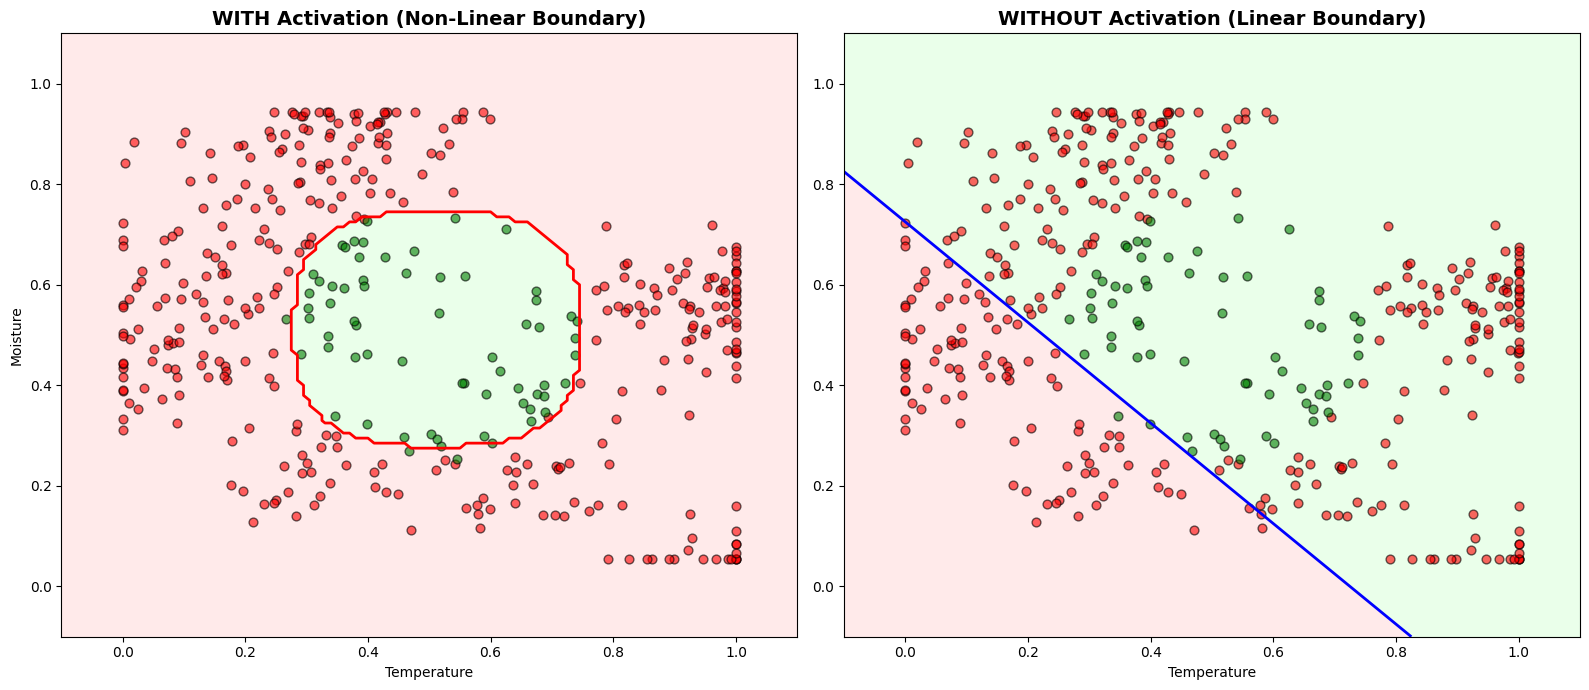

In [12]:
def compare_decision_boundaries(network, X, y):
    """
    Visualizes the decision boundary of the network with and without activation functions.
    
    The 'Without Activation' plot temporarily adjusts symmetric weights AND biases to 
    visualize the underlying linear boundary.
    """
    # 1. Setup grid
    h = 0.01
    x_min, x_max = -0.1, 1.1
    y_min, y_max = -0.1, 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # === PLOT 1: NON-LINEAR MODEL (WITH Activation) ===
    preds_poly, _, _ = network.forward(grid_tensor, use_activation=True)
    Z_poly = preds_poly.detach().numpy().reshape(xx.shape)
    
    axes[0].contourf(xx, yy, Z_poly, levels=[0, 0.5, 1], colors=['#ffcccc', '#ccffcc'], alpha=0.4)
    axes[0].contour(xx, yy, Z_poly, levels=[0.5], colors='red', linewidths=2)
    
    # Plot data points
    for i, label in enumerate(['Unhealthy', 'Healthy']):
        mask = y == i
        axes[0].scatter(X[mask, 0], X[mask, 1], c=['red', 'green'][i], label=label, edgecolor='k', s=40, alpha=0.6)
    
    axes[0].set_title("WITH Activation (Non-Linear Boundary)", fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Temperature')
    axes[0].set_ylabel('Moisture')

    # === PLOT 2: LINEAR MODEL (Symmetry and Bias Adjusted) ===
    # To reveal the linear boundary, we must remove the effect of the opposing W and b terms.
    # The opposing weights cancel out (20-20=0), resulting in a flat output that pushes the resulting straight line entirely off the chart.
    # We prevent this by temporarily zeroing out the weights and biases of the opposing neurons (Neuron 2 and Neuron 4).
    
    # Save original parameters to restore later
    original_W = network.W.clone()
    original_b = network.b.clone()
    
    # 1. Create modified weights (W): Zero out opposing forces (W[:, 1] and W[:, 3])
    W_linear_plot = network.W.clone()
    W_linear_plot[:, 1] = 0 
    W_linear_plot[:, 3] = 0 
    
    # 2. Create modified biases (b): Zero out biases of the disabled neurons (b[1] and b[3])
    b_linear_plot = network.b.clone()
    b_linear_plot[1] = 0
    b_linear_plot[3] = 0
    
    # Apply adjusted parameters to network
    network.W = torch.nn.Parameter(W_linear_plot)
    network.b = torch.nn.Parameter(b_linear_plot)
    
    # Run forward pass WITHOUT activation
    preds_linear, _, _ = network.forward(grid_tensor, use_activation=False)
    Z_linear = preds_linear.detach().numpy().reshape(xx.shape)
    
    axes[1].contourf(xx, yy, Z_linear, levels=[0, 0.5, 1], colors=['#ffcccc', '#ccffcc'], alpha=0.4)
    axes[1].contour(xx, yy, Z_linear, levels=[0.5], colors='blue', linewidths=2)
    
    # Plot data points
    for i, label in enumerate(['Unhealthy', 'Healthy']):
        mask = y == i
        axes[1].scatter(X[mask, 0], X[mask, 1], c=['red', 'green'][i], label=label, edgecolor='k', s=40, alpha=0.6)
    
    axes[1].set_title("WITHOUT Activation (Linear Boundary)", fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Temperature')
    
    # Restore original parameters 
    network.W = torch.nn.Parameter(original_W)
    network.b = torch.nn.Parameter(original_b)

    plt.tight_layout()
    plt.show()

# Run the visualization
compare_decision_boundaries(network, X_tensor, labels)

> **The breakthrough moment**: This side-by-side comparison shows exactly why activation functions revolutionized neural networks. 
> 
> - Without activation, even with multiple neurons in a layer, the network mathematically collapses to a single linear transformation—just a straight line. 
> - With sigmoid activation, the network can create the curved boundary needed to capture the elliptical pattern. Each neuron's sigmoid creates a smooth transition, and together they form the complex shape.
> 
> This is the core insight that ended the first AI winter and enabled modern deep learning.

## Conclusion

Congratulations! You've just witnessed how activation functions enable neural networks to capture curved patterns in data. By adding sigmoid activation, you transformed a linear classifier into one that can approximate elliptical decision boundaries.

**What you've learned:**

- [x] **Elliptical patterns are unsolvable with linear models** - no straight line can separate a circular region
- [x] **Activation functions enable curved boundaries** - sigmoid combines multiple simple linear features into a complex, curved shape
- [x] **Multiple neurons work together** - each neuron captures one aspect of the boundary (e.g., too hot, too cold)
- [x] **One line of code makes all the difference** - `torch.sigmoid(z)` vs just `z`

> **Key insight**: The sigmoid activation doesn't just squash values between 0 and 1; it fundamentally changes what the network can represent. Without it, stacking layers gives you nothing more than a single layer. With it, each neuron creates a non-linear feature that can be combined with others to define the curved boundary. Each neuron in your layer learned one piece of the puzzle (too hot? too cold? too wet? too dry?), and the activation function lets them collaborate non-linearly to create the elliptical boundary.

##### Next steps to explore:

- [ ] **What curved patterns may still be impossible with one single-layer + activation?** You've seen activation functions solve one connected curved region. But what if the healthy zones form multiple disconnected regions? Could this architecture handle patterns where plants thrive in opposite corners (cold+wet OR hot+dry) but not in the other combinations? 
<br>_[Check the exercise for the answer!]_